In [1]:
# bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import*
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn import linear_model,naive_bayes,neighbors,svm,gaussian_process
from sklearn.model_selection import cross_val_score

# définir le style de visualisation
%matplotlib inline
sns.set()


In [2]:
# Importer des données
df_train = pd.read_csv('E:/MachineLearning/DataBase/TitanicPredictions//train.csv')
df_test = pd.read_csv('E:/MachineLearning/DataBase/TitanicPredictions//test.csv')
# Stocker la variable cible des données d'entraînement dans un endroit sûr
survived_train = df_train['Survived']
# Concatiner les ensembles d'entraînement et de test
data =pd.concat([df_train.drop('Survived',axis=1),df_test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [3]:
def features_plots(discrete_vars):
    plt.figure(figsize=(15,24.5))
    for i,dv in enumerate(['Age','Fare']):
            plt.subplot(7,2,i+1)
            plt.hist(data[dv].dropna(),bins=len(data[dv].unique()))
            plt.title(dv)
            plt.ylabel('frequency')
    for i,dv in enumerate(discrete_vars):
            plt.subplot(7,2,i+3)
            data[dv].value_counts().plot(kind='bar',title=dv)
            plt.xticks(rotation=45)
            plt.ylabel('frequency')

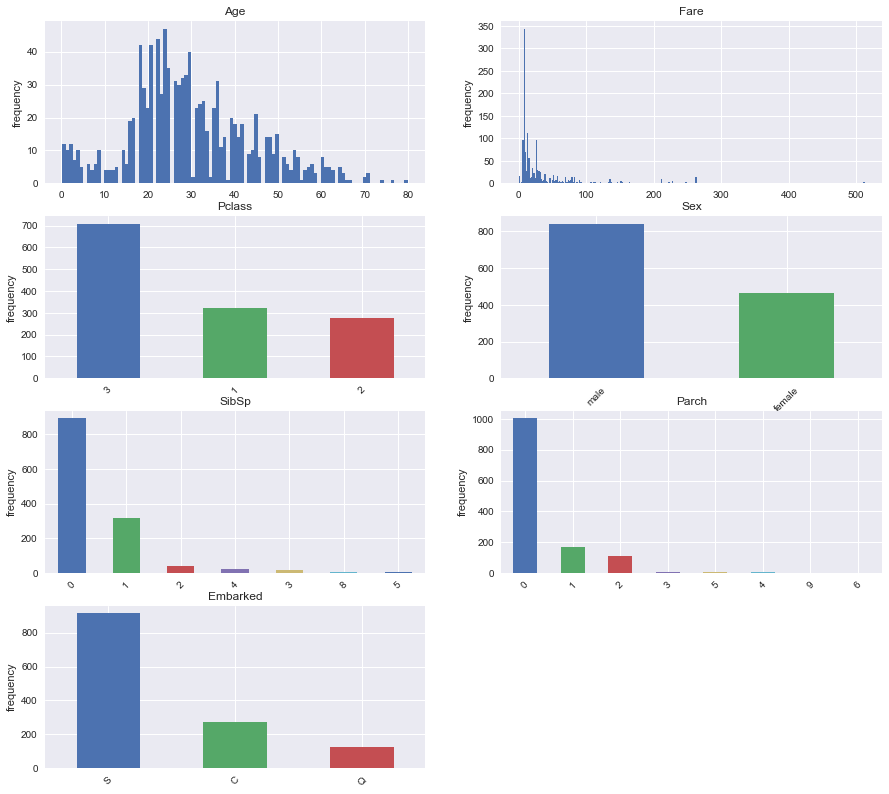

In [4]:
discrete_var=['Pclass', 'Sex', 'SibSp','Parch','Embarked']
features_plots(discrete_var)
plt.show()

# Performing Exploratory Data Analysis

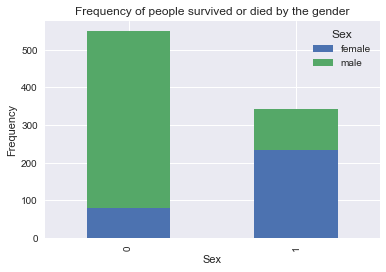

In [5]:
df_train.groupby(['Sex', 'Survived'])['Survived'].count().unstack('Sex').fillna(0).plot(kind='bar', stacked=True)
plt.title('Frequency of people survived or died by the gender')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

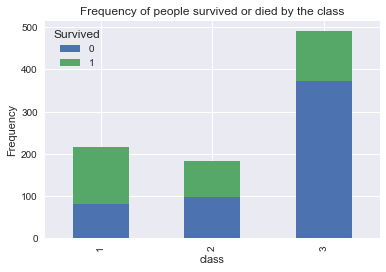

In [6]:
df_train.groupby(['Pclass','Survived'])['Pclass'].count().unstack('Survived').fillna(0).plot(kind='bar',stacked=True)
plt.title('Frequency of people survived or died by the class')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

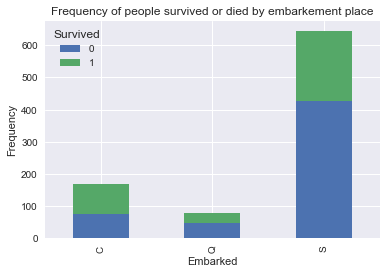

In [7]:
df_train.groupby(['Embarked', 'Survived'])['Embarked'].count().unstack('Survived').fillna(0).plot(kind='bar', stacked=True)
plt.title('Frequency of people survived or died by embarkement place')
plt.xlabel('Embarked')
plt.ylabel('Frequency')
plt.show()

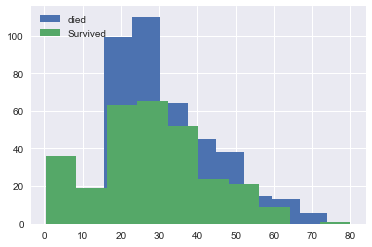

In [8]:
df_train.groupby('Survived').Age.hist(alpha=0.4)
plt.legend(['died', 'Survived'], loc='upper left')


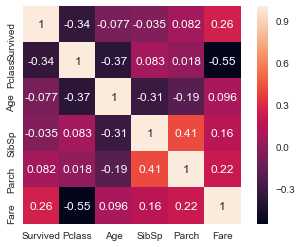

In [9]:
sns.heatmap(df_train.drop('PassengerId',axis=1).corr(),annot=True,square=True,vmax=1.0)

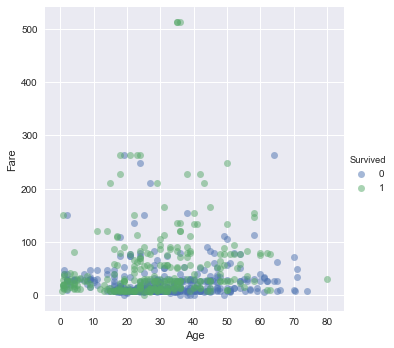

In [10]:
sns.lmplot(x='Age', y='Fare', hue='Survived', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

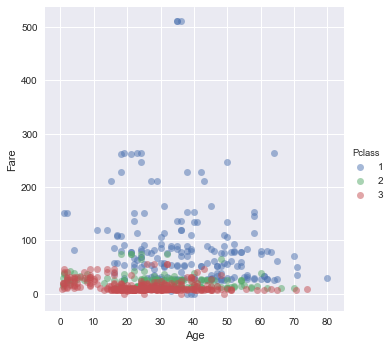

In [11]:
sns.lmplot(x='Age', y='Fare', hue='Pclass', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

# Features generation
In machine learning, the greater the number of observations and feature sets within the dataset, the greater the likelihood that the model will capture the variability within it,to understand its true essence

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Capt          1
Lady          1
Sir           1
Countess      1
Jonkheer      1
Dona          1
Mme           1
Name: Salutation, dtype: int64
0    757
2    264
1    198
3     61
4     29
Name: Salutation, dtype: int64


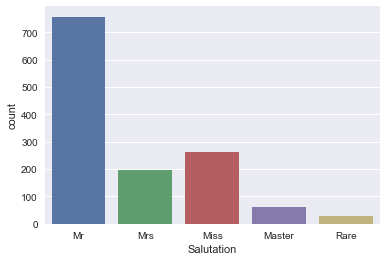

In [12]:
data['Salutation'] = data.Name.str.extract('([A-Za-z]+)\.',expand=False)    
print(data.Salutation.value_counts())
data['Salutation'] = data['Salutation'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Salutation'] = data['Salutation'].replace(['Ms','Mlle'], 'Miss')
data['Salutation'] = data['Salutation'].replace('Mme', 'Mrs')
sns.countplot(x='Salutation', data=data);

data['Salutation'] = pd.factorize(data['Salutation'])[0]
print(data.Salutation.value_counts())


In [13]:
#data['Family_size'] = data.SibSp+data.Parch+1

# MissingValues

In [14]:
data_fare_age=data[data['Fare']==0.00]['Age']
print(data_fare_age.isnull().sum())
data_fare_age.value_counts()

9


49.0    2
38.0    1
39.0    1
19.0    1
25.0    1
40.0    1
36.0    1
Name: Age, dtype: int64

In [15]:
GR_fare=data.groupby('Pclass')['Fare'].agg(np.median)
for i in range(len(GR_fare)):
    data.loc[(data['Fare'].isnull())&(data['Pclass']==i+1),'Fare']=GR_fare[i+1]

In [16]:
Age_salutation=data.groupby('Salutation')['Age'].agg(np.median)
for i in range(len(Age_salutation)):
    data.loc[(data['Age'].isnull())&(data['Salutation']==i),'Age']=Age_salutation[i]

In [17]:
data['Embarked'] = data['Embarked'].fillna('S')


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Salutation     1309 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 172.9+ KB


# Bin numerical data

In [19]:
data['Age'] = pd.qcut(data.Age, q=4, labels=False )
data['Fare']= pd.qcut(data.Fare, q=4, labels=False)

In [20]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation
0,1,3,"Braund, Mr. Owen Harris",male,0,1,0,A/5 21171,0,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,3,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,1,NaN,S,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,3,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,2,0,0,373450,1,NaN,S,0


# Categorical to numerical

In [21]:
data.Sex=pd.Categorical(data.Sex).codes
data.Embarked=pd.Categorical(data.Embarked).codes

data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation
0,1,3,"Braund, Mr. Owen Harris",1,0,1,0,A/5 21171,0,NaN,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,1,0,PC 17599,3,C85,0,1
2,3,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,2,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,2,1
4,5,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,2,0


In [22]:
data.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1,inplace=True)

In [23]:
data.head()
data_train = data.iloc[:891]
data_test = data.iloc[891:]
x=data_train
y=survived_train

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=23)

In [25]:
MLA = [

    #Trees    
    tree.DecisionTreeClassifier(max_depth=3),
    tree.ExtraTreeClassifier(),
    #Ensemble Methods
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    BaggingClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),


    ]

In [26]:
def evalu(model):
    MLA_col=[]
    MLA_tab=pd.DataFrame(columns=MLA_col)
    row_index=0
    for i,model in enumerate(MLA):
        model_name = model.__class__.__name__
        model.fit(x_train,y_train)
        y_pred=model.predict(x_test)
        MLA_tab.loc[row_index,'Model_name']=model_name
        MLA_tab.loc[row_index,'Test accuracy']=accuracy_score(y_test, y_pred)
        MLA_tab.loc[row_index,'Train accuracy']=model.score(x_train, y_train)
        MLA_tab.loc[row_index,'F1_score']=f1_score(y_test, y_pred)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        MLA_tab.loc[row_index,'AUC']=auc(false_positive_rate, true_positive_rate)
        roc_auc=auc(false_positive_rate, true_positive_rate)
        plt.title('roc_comparison')
        plt.plot(false_positive_rate, true_positive_rate, alpha=0.7,label='RoC for %s:AUC = %0.2f'% (model_name,roc_auc))
        row_index+=1
    plt.title('ROC Curve comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    return MLA_tab

C:\Users\Lenovo\Miniconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Lenovo\Miniconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Lenovo

,Model_name,Test accuracy,Train accuracy,F1_score,AUC
2,AdaBoostClassifier,0.815642,0.827247,0.731707,0.790693
4,GradientBoostingClassifier,0.815642,0.848315,0.697248,0.766440
17,NuSVC,0.815642,0.828652,0.722689,0.783764
0,DecisionTreeClassifier,0.810056,0.824438,0.679245,0.755163
16,SVC,0.810056,0.841292,0.679245,0.755163
15,KNeighborsClassifier,0.810056,0.841292,0.701754,0.769022
7,GaussianProcessClassifier,0.798883,0.851124,0.678571,0.753397
6,BaggingClassifier,0.787709,0.866573,0.683333,0.755095
3,ExtraTreesClassifier,0.782123,0.867978,0.677686,0.750747
5,RandomForestClassifier,0.782123,0.866573,0.677686,0.750747


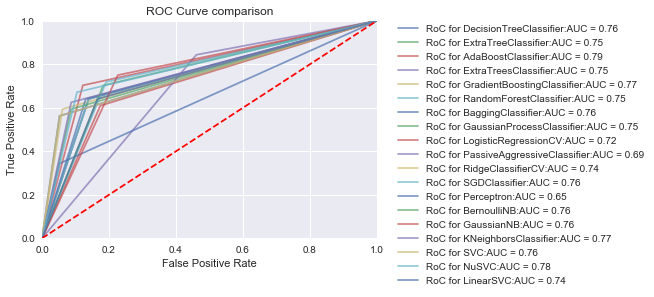

In [27]:
MLA_tab=evalu(MLA)
MLA_tab.sort_values(by='Test accuracy',ascending=False)

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

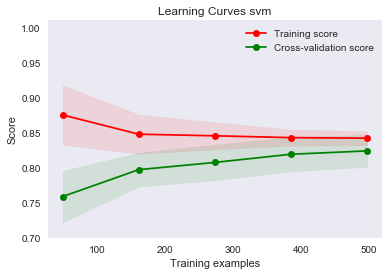

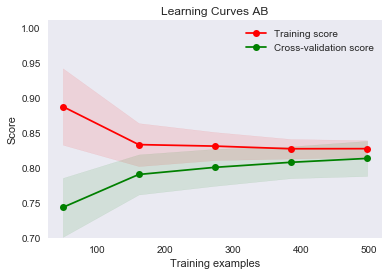

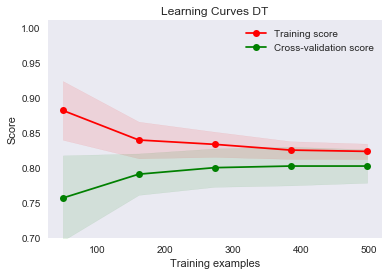

<module 'matplotlib.pyplot' from 'C:\Users\Lenovo\Miniconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [29]:
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)
plot_learning_curve(svm.SVC(probability=True), "Learning Curves svm", x_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plot_learning_curve(AdaBoostClassifier(), "Learning Curves AB", x_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plot_learning_curve(DecisionTreeClassifier(max_depth=3), "Learning Curves DT", x_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


In [30]:
clf=DecisionTreeClassifier(max_depth=3)
clf.fit(x,y)
y_pred=clf.predict(data_test)
df_test['Survived'] =y_pred
df_test[['PassengerId', 'Survived']].to_csv('./Predictions/DT',index=False)

accuray: 0.78947

In [31]:
clf=AdaBoostClassifier()
clf.fit(x,y)
y_pred=clf.predict(data_test)
df_test['Survived'] =y_pred
df_test[['PassengerId', 'Survived']].to_csv('./Predictions/AB',index=False)

accuracy:0.75598

In [32]:
clf=GradientBoostingClassifier()
clf.fit(x,y)
y_pred=clf.predict(data_test)
df_test['Survived'] =y_pred
df_test[['PassengerId', 'Survived']].to_csv('./Predictions/GB',index=False)

accuracy:0.80382

In [33]:
clf=BaggingClassifier()
clf.fit(x,y)
y_pred=clf.predict(data_test)
df_test['Survived'] =y_pred
df_test[['PassengerId', 'Survived']].to_csv('./Predictions/B',index=False)

accuracy:0.784

In [34]:
clf=svm.NuSVC(probability=True)
clf.fit(x,y)
y_pred=clf.predict(data_test)
df_test['Survived'] =y_pred
df_test[['PassengerId', 'Survived']].to_csv('./Predictions/NuSVC',index=False)

In [35]:
 accuracy:0.78947

SyntaxError: invalid syntax (<ipython-input-35-2ddf6a019435>, line 1)